# K-Means with Python - Clustering Short Creators in the Premier League
---


Football commentary and discussion is often based on putting players into boxes.

If we wanted to take a data-led approach to grouping player performances, we could use a method called `clustering`, allowing us to group players based on a set of their metrics. This might allow us to overcome some biases when analyzing players or uncover names that we might have previously thought of as playing in a different style.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Allow for full talbes to be shown
pd.options.display.max_columns = None
pd.options.display.max_rows = None

data = pd.read_csv('../csv/sca.csv')
data = data.drop(['GCA', 'GCA90', 'PassLive.1', 'PassDead.1', 'Drib.1', 'Sh.1', 'Fld.1', 'Matches', '-9999', 'Def', 'Def.1'], axis=1)
data = data.rename(columns={
  'PassLive': 'Pass SCA',
  'PassDead': 'Deadball SCA',
  'Drib': 'Dribble SCA',
  'Sh': 'Shot SCA',
  'Fld': 'Fouled SCA'
})
data.head()

,Rk,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,Pass SCA,Deadball SCA,Dribble SCA,Shot SCA,Fouled SCA
0,1,Brenden Aaronson,us USA,MFFW,Leeds United,22-089,2000,16.7,61,3.66,40,10,4,2,4
1,2,Che Adams,sct SCO,FW,Southampton,26-190,1996,15.8,42,2.66,33,1,1,4,3
2,3,Tyler Adams,us USA,MF,Leeds United,23-339,1999,16.0,31,1.94,30,0,0,0,1
3,4,Tosin Adarabioyo,eng ENG,DF,Fulham,25-117,1997,12.2,5,0.41,5,0,0,0,0
4,5,Nayef Aguerd,ma MAR,DF,West Ham,26-295,1996,2.8,1,0.35,1,0,0,0,0


## Check & Tidy Dataset

We have some biographical player information, along with shot creation numbers and their type.

In [6]:
# split nation names by the space, then use the second one
data['Nation'] = data['Nation'].str.split(' ', expand=True)[1]

# some positions have 2, so just use first two letters as main position
data['Pos'] = data['Pos'].str[:2]

# fix age
data['Age'] = data['Age'].str.split('-', expand=True)[0]

data.head(2)

,Rk,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,Pass SCA,Deadball SCA,Dribble SCA,Shot SCA,Fouled SCA
0,1,Brenden Aaronson,USA,MF,Leeds United,22,2000,16.7,61,3.66,40,10,4,2,4
1,2,Che Adams,SCO,FW,Southampton,26,1996,15.8,42,2.66,33,1,1,4,3


Another thing to consider is the effect of playing for a stronger team. As a broad assumption, we can expect players in better teams to create more shots, and players in worse teams to produce fewer.

This might produce results that group players based on their production levels, not the styles of their productions.

As such, let's create some new columns to look at the percentages for each action type. WE'll do this by creating a sum column, then dividing each column by the sum.

In [7]:
# create a list of columns to sum, then assign the sum to a new column
add_list = ['Pass SCA', 'Deadball SCA', 'Dribble SCA', 'Shot SCA', 'Fouled SCA']
data['Sum SCA'] = data[add_list].sum(axis=1)

# create our first new column
data['Pass SCA Ratio'] = data['Pass SCA'] / data['Sum SCA']
data.head()

,Rk,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,Pass SCA,Deadball SCA,Dribble SCA,Shot SCA,Fouled SCA,Sum SCA,Pass SCA Ratio
0,1,Brenden Aaronson,USA,MF,Leeds United,22,2000,16.7,61,3.66,40,10,4,2,4,60,0.666667
1,2,Che Adams,SCO,FW,Southampton,26,1996,15.8,42,2.66,33,1,1,4,3,42,0.785714
2,3,Tyler Adams,USA,MF,Leeds United,23,1999,16.0,31,1.94,30,0,0,0,1,31,0.967742
3,4,Tosin Adarabioyo,ENG,DF,Fulham,25,1997,12.2,5,0.41,5,0,0,0,0,5,1.000000
4,5,Nayef Aguerd,MAR,DF,West Ham,26,1996,2.8,1,0.35,1,0,0,0,0,1,1.000000


Brenden Aaronson's shot creations were from passes 66% of the time. Let's create the rest of the ratios in a loop.

First we'll create new column names in a loop. Then we will run another loop with the code thatw e just used to create our remaining columns.

In [8]:
# create new column names by adding ' ratio' to each name in our previous list
new_cols_list = [each + ' Ratio' for each in add_list]

# for each new column, calculate the column exactly as we did before
for idx, val in enumerate(new_cols_list):
  data[val] = data[add_list[idx]] / data['Sum SCA']

# create a sum of the percentages to check that they all add to 1
data['Sum SCA Ratio'] = data[new_cols_list].sum(axis=1)
data.head(5)

,Rk,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,Pass SCA,Deadball SCA,Dribble SCA,Shot SCA,Fouled SCA,Sum SCA,Pass SCA Ratio,Deadball SCA Ratio,Dribble SCA Ratio,Shot SCA Ratio,Fouled SCA Ratio,Sum SCA Ratio
0,1,Brenden Aaronson,USA,MF,Leeds United,22,2000,16.7,61,3.66,40,10,4,2,4,60,0.666667,0.166667,0.066667,0.033333,0.066667,1.0
1,2,Che Adams,SCO,FW,Southampton,26,1996,15.8,42,2.66,33,1,1,4,3,42,0.785714,0.023810,0.023810,0.095238,0.071429,1.0
2,3,Tyler Adams,USA,MF,Leeds United,23,1999,16.0,31,1.94,30,0,0,0,1,31,0.967742,0.000000,0.000000,0.000000,0.032258,1.0
3,4,Tosin Adarabioyo,ENG,DF,Fulham,25,1997,12.2,5,0.41,5,0,0,0,0,5,1.000000,0.000000,0.000000,0.000000,0.000000,1.0
4,5,Nayef Aguerd,MAR,DF,West Ham,26,1996,2.8,1,0.35,1,0,0,0,0,1,1.000000,0.000000,0.000000,0.000000,0.000000,1.0


We have lods of decimals adding to 1 that we can consider as percentages for each type of action.

If we have any goalkeepers in the dataset, this won't be useful for shot creation profiles.

We'll create a new dataframe that will only ask for forwards or midfielders. We'll also set a floor for playing time and shtos created to cut out anyone with low appearance or creation numbers. These numbers are arbitrary, so feel free to change them into something more useful.

In [10]:
# New dataframe where Pos == FW or MF. AND played more than 5 90s AND created more than 15 shots
data_mffw = data[((data['Pos'] == 'FW') | (data['Pos'] == 'MF')) & (data['90s'] > 5) & (data['SCA'] > 15)]

data_mffw.head()

,Rk,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,Pass SCA,Deadball SCA,Dribble SCA,Shot SCA,Fouled SCA,Sum SCA,Pass SCA Ratio,Deadball SCA Ratio,Dribble SCA Ratio,Shot SCA Ratio,Fouled SCA Ratio,Sum SCA Ratio
0,1,Brenden Aaronson,USA,MF,Leeds United,22,2000,16.7,61,3.66,40,10,4,2,4,60,0.666667,0.166667,0.066667,0.033333,0.066667,1.0
1,2,Che Adams,SCO,FW,Southampton,26,1996,15.8,42,2.66,33,1,1,4,3,42,0.785714,0.023810,0.023810,0.095238,0.071429,1.0
2,3,Tyler Adams,USA,MF,Leeds United,23,1999,16.0,31,1.94,30,0,0,0,1,31,0.967742,0.000000,0.000000,0.000000,0.032258,1.0
10,11,Thiago Alcántara,ESP,MF,Liverpool,31,1991,10.9,30,2.76,25,0,1,1,1,28,0.892857,0.000000,0.035714,0.035714,0.035714,1.0
15,16,Miguel Almirón,PAR,FW,Newcastle Utd,28,1994,17.5,53,3.04,39,1,5,5,3,53,0.735849,0.018868,0.094340,0.094340,0.056604,1.0


## Create k-means model and assign each player into a cluster of similar players

Now that we are happy with our dataset, we can look to get our players clustered into groups.

As simply as possible, the method splits all of our playters into a number of clusters that we decide.

One way that it does this is by putting the centre of the clusters somewhere at random in our data. From here, the players are assigned a cluster based on which one they are closest to.

The cluster's location then changes to the average of its players' datapoints and the clusters are re-assigned. This process repeats until no players change their membership after the cluster centres move to their new average. Once this process stops, we then have our final clusters.

We will use the scikit learn module that we imported at the beginning. Within the module, we will use the k-means function and assign a model to the variable `km` below.

In [15]:
km = KMeans(n_clusters=5, init='random', random_state=0, n_init=10)

- `n_clusters=5`: simply how many clusters should we create? We have chosen 5 for no particular reason, but there are ways to see how many clusters you have.
- `init='random'`: how shoudl we pick where to try witho ur first clusters? We have selected at random and...
- `random_state=0`: is here to keep my random first cluters in the same place each time. You should remove this argument entirely if you want your analysis to use a `random` that will change each time.
- `n_init=10`: to supress a warning because default `n_init` will change to `auto` in 1.4

We are just asking for a KMeans model that will put our data into 5 clusters.

In [16]:
y_km = km.fit_predict(data_mffw[new_cols_list])
y_km

array([0, 2, 3, 3, 2, 0, 1, 3, 3, 3, 3, 2, 1, 1, 2, 2, 3, 2, 3, 1, 2, 3,
       3, 2, 0, 2, 2, 3, 0, 2, 1, 2, 2, 2, 3, 0, 4, 3, 3, 2, 3, 3, 3, 3,
       2, 3, 0, 1, 4, 2, 4, 1, 3, 0, 2, 4, 3, 3, 4, 3, 2, 3, 3, 4, 1, 2,
       1, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 4, 2, 1, 0,
       0, 1, 3, 3, 1, 2, 4, 2, 2, 3, 4, 2, 3, 3, 2, 3, 1, 3, 1, 0, 3, 1,
       2, 0, 2, 3, 3, 3, 3, 1, 3, 3, 1, 0, 3, 1, 2, 2, 2, 4, 2, 2, 0, 3,
       1, 3, 3, 1, 1, 0], dtype=int32)

Let's assign them to corresponding players by adding them as a new column.

In [17]:
data_mffw['Cluster'] = y_km
data_mffw.head()

/tmp/ipykernel_1807/3611811896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mffw['Cluster'] = y_km


,Rk,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,Pass SCA,Deadball SCA,Dribble SCA,Shot SCA,Fouled SCA,Sum SCA,Pass SCA Ratio,Deadball SCA Ratio,Dribble SCA Ratio,Shot SCA Ratio,Fouled SCA Ratio,Sum SCA Ratio,Cluster
0,1,Brenden Aaronson,USA,MF,Leeds United,22,2000,16.7,61,3.66,40,10,4,2,4,60,0.666667,0.166667,0.066667,0.033333,0.066667,1.0,0
1,2,Che Adams,SCO,FW,Southampton,26,1996,15.8,42,2.66,33,1,1,4,3,42,0.785714,0.023810,0.023810,0.095238,0.071429,1.0,2
2,3,Tyler Adams,USA,MF,Leeds United,23,1999,16.0,31,1.94,30,0,0,0,1,31,0.967742,0.000000,0.000000,0.000000,0.032258,1.0,3
10,11,Thiago Alcántara,ESP,MF,Liverpool,31,1991,10.9,30,2.76,25,0,1,1,1,28,0.892857,0.000000,0.035714,0.035714,0.035714,1.0,3
15,16,Miguel Almirón,PAR,FW,Newcastle Utd,28,1994,17.5,53,3.04,39,1,5,5,3,53,0.735849,0.018868,0.094340,0.094340,0.056604,1.0,2


## Describe and Visualize Results

Let's check the first group and see what's going on.

In [27]:
data_mffw[data_mffw['Cluster'] == 0].head(10)

,Rk,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,Pass SCA,Deadball SCA,Dribble SCA,Shot SCA,Fouled SCA,Sum SCA,Pass SCA Ratio,Deadball SCA Ratio,Dribble SCA Ratio,Shot SCA Ratio,Fouled SCA Ratio,Sum SCA Ratio,Cluster
0,1,Brenden Aaronson,USA,MF,Leeds United,22,2000,16.7,61,3.66,40,10,4,2,4,60,0.666667,0.166667,0.066667,0.033333,0.066667,1.0,0
20,21,Jaidon Anthony,ENG,MF,Bournemouth,23,1999,6.1,17,2.78,11,2,1,1,1,16,0.687500,0.125000,0.062500,0.062500,0.062500,1.0,0
93,94,Lewis Cook,ENG,MF,Bournemouth,25,1997,16.5,32,1.94,21,7,0,0,1,29,0.724138,0.241379,0.000000,0.000000,0.034483,1.0,0
111,112,Kevin De Bruyne,BEL,MF,Manchester City,31,1991,16.6,107,6.46,75,19,3,7,1,105,0.714286,0.180952,0.028571,0.066667,0.009524,1.0,0
143,144,Christian Eriksen,DEN,MF,Manchester Utd,30,1992,15.5,50,3.21,35,13,1,1,0,50,0.700000,0.260000,0.020000,0.020000,0.000000,1.0,0
176,177,Morgan Gibbs-White,ENG,FW,Nott'ham Forest,22,2000,14.3,57,3.99,36,11,6,2,0,55,0.654545,0.200000,0.109091,0.036364,0.000000,1.0,0
192,193,İlkay Gündoğan,GER,MF,Manchester City,32,1990,11.9,51,4.27,40,7,0,3,0,50,0.800000,0.140000,0.000000,0.060000,0.000000,1.0,0
276,277,Douglas Luiz,BRA,MF,Aston Villa,24,1998,14.0,40,2.86,29,7,1,1,1,39,0.743590,0.179487,0.025641,0.025641,0.025641,1.0,0
278,279,Alexis Mac Allister,ARG,MF,Brighton,24,1998,15.2,34,2.24,25,5,0,2,1,33,0.757576,0.151515,0.000000,0.060606,0.030303,1.0,0
279,280,James Maddison,ENG,MF,Leicester City,26,1996,12.2,57,4.67,36,10,3,3,3,55,0.654545,0.181818,0.054545,0.054545,0.054545,1.0,0


It would help to understand the clusters by visualizing them with a scatter plot featuring two columns.

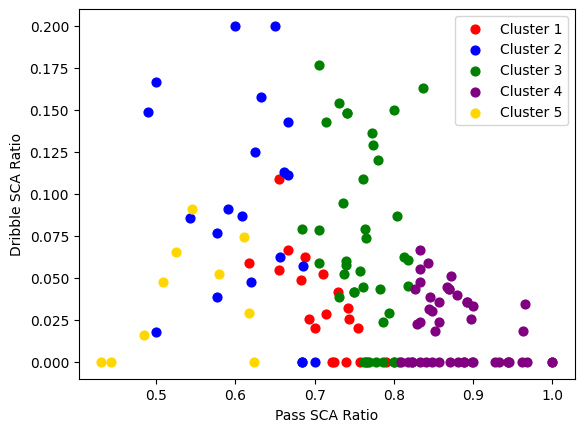

In [30]:
def plotClusters(xAxis, yAxis):
  plt.scatter(data_mffw[data_mffw['Cluster'] == 0][xAxis], data_mffw[data_mffw['Cluster'] == 0][yAxis], s=40, c='red', label='Cluster 1')
  plt.scatter(data_mffw[data_mffw['Cluster'] == 1][xAxis], data_mffw[data_mffw['Cluster'] == 1][yAxis], s=40, c='blue', label='Cluster 2')
  plt.scatter(data_mffw[data_mffw['Cluster'] == 2][xAxis], data_mffw[data_mffw['Cluster'] == 2][yAxis], s=40, c='green', label='Cluster 3')
  plt.scatter(data_mffw[data_mffw['Cluster'] == 3][xAxis], data_mffw[data_mffw['Cluster'] == 3][yAxis], s=40, c='purple', label='Cluster 4')
  plt.scatter(data_mffw[data_mffw['Cluster'] == 4][xAxis], data_mffw[data_mffw['Cluster'] == 4][yAxis], s=40, c='gold', label='Cluster 5')
  plt.xlabel(xAxis)
  plt.ylabel(yAxis)
  plt.legend()

plotClusters('Pass SCA Ratio', 'Dribble SCA Ratio')

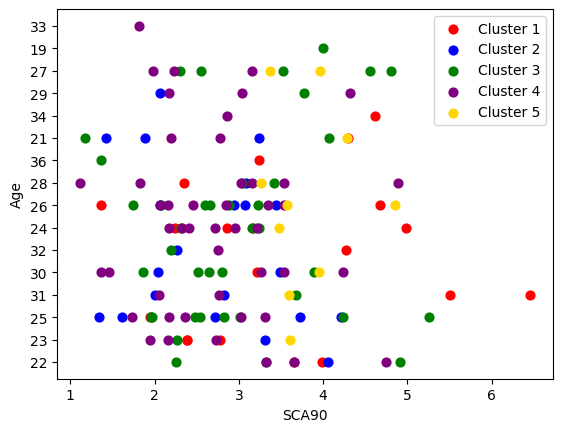

In [31]:
plotClusters('SCA90', 'Age')